In [1]:
from seirsplus.models import *
import networkx
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
from hyperopt import hp
from functools import partial
from matplotlib import pyplot as plt
from hyperopt import fmin, tpe, space_eval, Trials
import math
from kneed import DataGenerator, KneeLocator

## Common Function Definitions

In [2]:
#### Since the model outputs a different format than the CSSEGISandData, we need to align them
#### which means - finding the appropriate prediction for the model for a particular date

### modelI - Time Series Prediction output by model (model.numI)
### modelT - Time Series of the model (model.tseries)
### dates  - dates in the true file that we have from CSSEGISandData - datetime object


def alignTimeSeries(modelI, modelT, dates):
#     datesS = ['3/21/20', '3/22/20', '3/23/20', '3/24/20', '3/25/20']
#     dates = []
#     for date in datesS:
#         dates.append(datetime.strptime(date, "%m/%d/%y"))
    finalModelPredictions = []
    count = 0
    day0 = dates[0]
    for date in dates:
        t = (date-day0).days
        #print(t)
        while(modelT[count]<=t):
            count+=1
            if(count == len(modelT)):
                print("Last prediction reached - Number of predictions less than required")
                finalModelPredictions.append(modelI[count-1])
                finalModelPredictions_df = pd.DataFrame()
                finalModelPredictions_df['date'] = [date.strftime("%-m/%-d/%y") for date in dates]
                finalModelPredictions_df['predicted_count'] = finalModelPredictions
                return finalModelPredictions_df
        
        x0 = modelI[count] - (((modelI[count] - modelI[count-1])/(modelT[count] - modelT[count-1]))*(modelT[count] -  t))
        finalModelPredictions.append(x0)
#         diff1 = t - modelT[count-1]
#         diff2 = modelT[count] - t
#         if(diff1<=diff2):
#             finalModelPredictions.append(modelI[count-1])
#             count -=1
#         else:
#             finalModelPredictions.append(modelI[count])
        
    
    finalModelPredictions_df = pd.DataFrame()
    finalModelPredictions_df['date'] = [date.strftime("%-m/%-d/%y") for date in dates]
    finalModelPredictions_df['predicted_count'] = finalModelPredictions
      
    return finalModelPredictions_df

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def compute_mape(orig, pred, index, verbose):
    merge = orig.merge(pred, right_on="date", left_on='date')
    merge = merge.dropna()
    if(verbose):
        print(merge)
    y_true = np.array(merge[index])
    y_pred = np.array(merge["predicted_count"])
    mape = 0
    for i in range(len(y_pred)):
        if(not y_true[i] == 0):
            mape+= np.abs((y_true[i] - y_pred[i] + 0.) / y_true[i])
    mape = (100*mape)/len(y_pred)
    return mape

def rmse_error(orig, pred, index, verbose):
    merge = orig.merge(pred, right_on="date", left_on='date')
    merge = merge.dropna()
    if(verbose):
        print(merge)
    y_true = np.array(merge[index])
    y_pred = np.array(merge["predicted_count"])
    rmse = 0
    
    for i in range(len(y_pred)):
        if(not y_true[i] == 0):
            rmse+= (y_true[i] - y_pred[i])**2
            
    rmse = math.sqrt(rmse/len(y_true))
    return rmse

def populate_missing_days(df,date_col,min_date,max_date):    
    r = pd.date_range(start=min_date, end=day0) 
    df = df.set_index(date_col).reindex(r).fillna(0.0).rename_axis(date_col).reset_index()
    return df


def convert_input_data_format(patient_data_file, date_col, region, region_col,region_population_data_file, out_file, min_date ,max_date ):
    
    patient_data_df = pd.read_csv(patient_data_file,na_values='')
    #patient_data_df = patient_data_df[(patient_data_df.state=='Kerala') | (patient_data_df.state=='Bihar')]
    region_population = pd.read_csv(region_population_data_file,sep=',')
    
    patient_data_df[region_col] = patient_data_df[region_col].str.strip()
    region_population[region_col] = region_population[region_col].str.strip()
    
    region_population_df = region_population.loc[:,[region_col,'population']]
    patient_data_df = patient_data_df.merge(region_population_df,on=region_col)
        
    patient_data_df['reported_date'] = pd.to_datetime(patient_data_df['reportedOn'], infer_datetime_format=True)
    end = datetime.today()
    patient_data_df['reported_date'] = patient_data_df['reported_date'].fillna(end)
    
    all_regions_df = pd.DataFrame()
    region_names = patient_data_df[region_col].unique()
    print(patient_data_df.columns)
    
    for region in region_names:
        region_filtered_df = patient_data_df[patient_data_df[region_col]==region]
        grouped_df = region_filtered_df.groupby(date_col)['patientId'].nunique().reset_index()

        grouped_df = grouped_df.sort_values(by=date_col, ascending=True)
        grouped_df = populate_missing_days(grouped_df,date_col,min_date,max_date)
        
        grouped_df['date'] = grouped_df[date_col]
        grouped_df['active_cases_count'] = grouped_df['patientId'].rolling(min_periods=1, window=recovery_days).sum()
        grouped_df['active_cases_count'] = grouped_df['active_cases_count'] * under_reporting_factor
        grouped_df['active_cases_count'] = grouped_df['active_cases_count'].round()
        #print(grouped_df)
        
        temp = grouped_df.loc[:,['date','active_cases_count']].transpose()
        temp.columns = temp.iloc[0]
        temp = temp.drop(temp.index[0])
        temp['current_recovered_count'] = region_filtered_df[region_filtered_df.status=='Recovered'].shape[0]
        temp[region_col] = region 
        temp['population'] = region_filtered_df['population'].mean()
        
        
        row_dict = temp.to_dict()
       
        all_regions_df = all_regions_df.append(temp)
    
    all_regions_df.to_csv(out_file)
    return all_regions_df

def reciprocal_list(input_list):
    return np.reciprocal(list(map(input_list,float)))        

def predict(region_row, infected_col_name, fixedParams, search_space, recovered_count, n_days, model_type='deterministic'):
    if(model_type=='deterministic'):        
#         init_beta = search_space['transmission_rate'][0]
        r0 = search_space['r0']
        init_sigma = 1./fixedParams['incubation_period'][0]
        init_beta = r0*init_sigma
        init_gamma = 1./fixedParams['infectious_period'][0]
        initN = region_row['population']
        initI = region_row[infected_col_name]
        initE = region_row[infected_col_name] * search_space['EbyIRation'] ### CHECK EXPOSURE - 50-100
        initR = recovered_count
        model = SEIRSModel(beta=init_beta, sigma=init_sigma, gamma=init_gamma, initN=initN, initI=initI, initE = initE, initR = initR)
        
        
        
        if(len(fixedParams['time_stamps'])>1):
            checkpoints = {
                't' : params['time_stamps'],
                'sigma' : reciprocal_list(params['incubation_period']), 
                'gamma' : reciprocal_list(params['infectious_period']),
                'beta' : params['transmission_rate']
            }
            
            model.run(T=n_days, checkpoints=checkpoints,verbose=False)            
        else:
            model.run(T=n_days,verbose=False)
    return model.tseries ,model.numI


## Top level function

In [3]:
def run1(search_space, time_series_file,population_file, recovered_count_file, region_col, day0, 
         n_days, fixedParams, day0recoveredCount = 16, isPlot = True, opt = 'rmse', verbose = True):
    print(search_space)
    region_timeseries_df = pd.read_csv(time_series_file)
#     population_file = pd.read_csv(population_file)
#     population_file = population_file[['state', 'population']]
    
#     region_timeseries_df = region_timeseries_df.merge(population_file, right_on = "state", left_on = 'Province/State')
#     region_timeseries_df = region_timeseries_df.drop(['state', 'Lat', 'Long'], axis = 1)
    
#     recovered_count_df = pd.read_csv(recovered_count_file)
#     region_timeseries_df = region_timeseries_df.merge(recovered_count_df, on='Province/State')
    
    region_timeseries_df = region_timeseries_df.groupby([region_col]).agg('sum')
    #print(region_timeseries_df)
    #print(region_timeseries_df.index)
    dates_str = []
    dates_dt = []
    mape_score = 0
    rmse = 0
    count = 0
    day0 = datetime.strptime(day0, "%m/%d/%y")
    for i in range(n_days):
        date = (day0 + timedelta(days=i))
        #print(date.strftime(format='%Y-%m-%d %M:%H:%S').strip())
        dates_dt.append(date)
        dates_str.append(date.strftime(format="%-m/%-d/%y").strip())
    
    for index, row in region_timeseries_df.iterrows():
        print(row['current_recovered_count'])
        time, predicted = predict(row, day0.strftime("%-m/%-d/%y"), fixedParams, search_space, row['current_recovered_count'], n_days, model_type)
        predicted_ts = alignTimeSeries(predicted, time, dates_dt)
        
        orig_row = pd.DataFrame(region_timeseries_df.loc[index, dates_str])
        orig_row = orig_row.reset_index()
        orig_row = orig_row.rename(columns ={ 'index': 'date'})
        mape_score += compute_mape(orig_row, predicted_ts, index, False)        
        rmse += rmse_error(orig_row, predicted_ts, index, verbose)
        count+=1
        summary_df = pd.DataFrame()
        
        if(isPlot):
            #print(predicted_ts)
            #summary_df.insert(column=region_col,value=index,loc=0)
            #summary_df.insert(0, region_col, index)
            summary_df['date'] = dates_dt
            summary_df[region_col] = index
            #print(index)
            #summary_df[region_col] = index
            summary_df['RMSE'] = rmse_error(orig_row, predicted_ts, index, False)
            summary_df['MAPE'] = compute_mape(orig_row, predicted_ts, index, False)
            summary_df['true_count'] = orig_row[index]
            summary_df['predicted_count'] = predicted_ts['predicted_count']
            summary_df['hospitalizations_count'] = (F_hospitalized * predicted_ts['predicted_count']).round()
            summary_df['ICU_count'] = (F_need_ICU * predicted_ts['predicted_count']).round()
            summary_df['ventilator_count'] = (F_need_Ventilator * predicted_ts['predicted_count']).round()
            summary_df['fatality_count'] = (F_fatality * predicted_ts['predicted_count']).round()
            summary_df['fatality_count'] = (F_fatality * predicted_ts['predicted_count']).round()
        
        
            summary_df['peak_date'] = summary_df.iloc[summary_df['predicted_count'].idxmax()]['date']
            summary_df['peak_infections'] = summary_df.iloc[summary_df['predicted_count'].idxmax()]['predicted_count']
        
            #print(summary_df)
            kneedle = KneeLocator(summary_df.index, summary_df['predicted_count'], S=1.0, curve='convex', direction='increasing')
            #print(index)
            if(pd.notnull(kneedle.knee)):
                summary_df['knee_point_date'] = summary_df.iloc[kneedle.knee,summary_df.columns.get_loc('date')]
            else:
                summary_df['knee_point_date'] = None
            
            
#             outpath = index + "_" + "_medical_demand_timeseries_Tinc"+str(fixedParams['incubation_period'][0])+"_Tinf"+str(fixedParams['infectious_period'][0]) + ".csv"
#             summary_df.to_csv(outpath)
            fig, ax = plt.subplots(figsize=(15,5))
            ax.plot(summary_df['date'], summary_df['predicted_count'], color = '#701805', label = "infections_r0_{}".format(search_space['r0']))
            ax.plot(summary_df['date'], summary_df['hospitalizations_count'], color = '#cf563e', label = "hospitalizations_r0_{}".format(search_space['r0']))
            ax.plot(summary_df['date'], summary_df['ICU_count'], color = '#e39191', label = "ICU requirement_r0_{}".format(search_space['r0']))
            ax.plot(summary_df['date'], summary_df['ventilator_count'], color = '#cf823e', label = "ventilators requirement_r0_{}".format(search_space['r0']))
            ax.plot(summary_df['date'], summary_df['fatality_count'], color = '#bdb56d', label = "fatalities_r0_{}".format(search_space['r0']))
            ax.plot(summary_df['date'], summary_df['true_count'], color = '#0000FF', label = "True Count")
            plt.xlabel("Time")
            plt.ylabel("SEIR Projections")
            plt.title(index)
            ax.legend()
#     print(mape_score, count, "MAPE")
    mape_score = mape_score/count
    rmse = rmse/count
#     print(mape_score, "mape_score")
#     print(rmse, "rmse")
    if(opt == 'mape'):
        return mape_score
    else:
        return rmse

In [4]:
def run_and_plot(input_file, pop_file,recovered_count_file, n_days_val, n_days_test, region_col, fixedParams,day0recoveredCount, search_space,max_evals, isPlot ,opt):
    tuneParameters = partial(run1, time_series_file = input_file, population_file = pop_file,recovered_count_file = recovered_count_file, region_col = region, 
                   day0 = day0, n_days = n_days_val, fixedParams = fixedParams, 
                    day0recoveredCount = 16, isPlot= False, opt = opt, verbose = False)

    trials = Trials()
    best = fmin(tuneParameters, search_space, algo=tpe.suggest, max_evals=max_evals, trials = trials)
    print("Best fit:", space_eval(search_space, best))
    trialDict = dict()
    for trial in trials:
        trialDict[(trial['misc']['vals']['EbyIRation'][0],trial['misc']['vals']['r0'][0])] = trial['result']['loss']
        sortedTrialDict = [(k, v) for k, v in sorted(trialDict.items(), key=lambda item: item[1])]
    
    best_params = {
    'r0' : space_eval(search_space, best)['r0'],
    'EbyIRation': space_eval(search_space, best)['EbyIRation']
    }
    
    valError = sortedTrialDict[0][1]
    if( not n_days_test == -1):
        day0new = datetime.strftime((datetime.strptime(day0,"%m/%d/%y") + timedelta(days=n_days_val-1)), "%-m/%-d/%y")
        print("Running for test")
        testError = run1(best_params, input_file, pop_file,recovered_count_file, region_col, day0new, n_days_test, fixedParams, day0recoveredCount, False, opt = opt, verbose = False)
        if(isPlot):
            run1(best_params, input_file, pop_file,recovered_count_file, region_col, day0, (n_days_val+n_days_test) , fixedParams, day0recoveredCount, True, opt = opt, verbose = True)
    
        print("Validation Error:" + str(valError))
        print("Test Error:" + str(testError))
        return sortedTrialDict

    else:
        if(isPlot):
            run1(best_params, input_file, pop_file,recovered_count_file, region_col, day0, (n_days_val) , fixedParams, day0recoveredCount, True, opt = opt, verbose = True)
    
        print("Validation Error:" + str(valError))
        return sortedTrialDict
        

In [66]:
def prepare_data(region_col, region_name, population, day0, outputFileName, global_file_name, globalRecovered_file_name):
    region_timeseries_df = pd.read_csv(global_file_name)
    region_timeseries_df = region_timeseries_df.groupby([region_col]).agg('sum')
    region_timeseries_df= region_timeseries_df.reset_index()
    recovered = pd.read_csv(globalRecovered_file_name)
    recovered = recovered.reset_index()
    recovered = recovered[[region_col, day0]]
    recovered = recovered.rename(columns = {day0: 'current_recovered_count'})
    recovered = recovered.groupby([region_col]).agg('sum')
    merged = region_timeseries_df.merge(recovered, on = region_col)
    merged = merged[merged[region_col] == region_name]
    merged['population'] = population
    merged.to_csv(outputFileName)

In [67]:
pop_file = 'state_population.csv'
recovered_count_file = 'statewise_recovered_counts.csv'

n_days_val = 15
n_days_test = 400
# search_space = {
#    'r0' : hp.choice('r0',[0.00001]),
#    'EbyIRation': hp.choice('EbyIRation', [1.12])    
# }

F_hospitalized =  .26
F_need_ICU = .082
F_need_Ventilator = .05
F_fatality = .026

search_space = {
     'r0' : hp.uniform('r0', 0.8, 7),
     'EbyIRation': hp.uniform('EbyIRation', 1, 60)
 }

fixedParams = {'time_stamps' : [1],
               'infectious_period' : [2.9], #2-4 2.9, 14
               'incubation_period' : [5.2]  # 4-7 5.2, 4
              }

model_type = 'deterministic'
day0 = '1/30/20' # "%m/%d/%y"
global_file_name = './time_series_covid19_confirmed_global.csv'
globalRecovered_file_name = './time_series_covid19_recovered_global.csv'

region = 'Country/Region'
# region = 'Province/State'

region_name = 'China'
population = 1437995152
input_file = './time_series_{}.csv'.format(region_name)

prepare_data(region_col = region, region_name=region_name, population= population, day0=day0, outputFileName = input_file, 
             global_file_name=global_file_name, globalRecovered_file_name= globalRecovered_file_name)
 
error = 'mape'
max_evals = 10

{'EbyIRation': 21.973383071624887, 'r0': 2.5432148210295806}
135.0                                                 
t = 14.90                                             
{'EbyIRation': 17.87209544499228, 'r0': 5.5411822206321855}
135.0                                                                      
t = 14.90                                                                  
{'EbyIRation': 8.667334637493848, 'r0': 2.807141610586414}                 
135.0                                                                      
t = 14.90                                                                  
{'EbyIRation': 39.27980404577994, 'r0': 2.7728745567942537}                
135.0                                                                      
t = 14.90                                                                  
{'EbyIRation': 50.9497565636716, 'r0': 3.714159882553229}                  
135.0                                                                      
t = 14.90

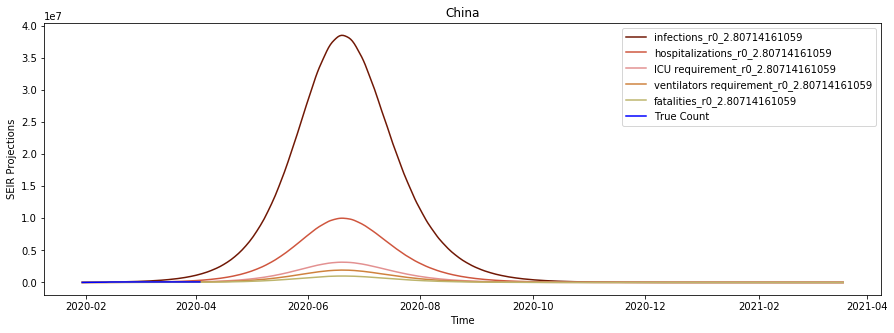

In [68]:
sorted_dict = run_and_plot(input_file, pop_file,recovered_count_file, n_days_val, n_days_test, region, fixedParams, 16, search_space=search_space,max_evals=max_evals, isPlot=True ,opt=error)


In [ ]:
day0new = datetime.strptime('4/1/20', "%m/%d/%y")

In [ ]:
datetime.strftime(day0new, "%-m/%-d/%y")

In [ ]:
region_timeseries_df = pd.read_csv('./time_series_covid19_confirmed_global.csv')

In [ ]:
region_timeseries_df

In [ ]:
region_timeseries_df = region_timeseries_df.groupby(['Country/Region']).agg('sum')

In [ ]:
region_timeseries_df= region_timeseries_df.reset_index()
# region_timeseries_df = region_timeseries_df[region_timeseries_df['Country/Region'] == 'China']

In [ ]:
merged = region_timeseries_df.merge(recovered, on = 'Country/Region')

In [ ]:
merged = merged[merged['Country/Region'] == 'China']

In [ ]:
merged

In [ ]:
merged['population'] = 201232

In [ ]:
merged

In [ ]:
region_timeseries_df['population'] = 1437995152
region_timeseries_df['current_recovered_count'] = 28

In [ ]:
region_timeseries_df['3/5/20']

In [ ]:
region_timeseries_df.to_csv('./time_series_China.csv')

In [ ]:
recovered = pd.read_csv('./time_series_covid19_recovered_global.csv')

In [ ]:
recovered = recovered.groupby(['Country/Region']).agg('sum')

In [ ]:
recovered = recovered.reset_index()

In [ ]:
recovered = recovered[['Country/Region', '1/25/20']]
recovered = recovered.rename(columns = {'1/25/20': 'recovered_count'})

In [ ]:
recovered

In [ ]:
recovered[recovered['Country/Region'] == 'China']

In [ ]:
def prepare_data(country, population, day0, outputFileName, global_file_name, globalRecovered_file_name):
    region_timeseries_df = pd.read_csv(global_file_name)
    region_timeseries_df = region_timeseries_df.groupby(['Country/Region']).agg('sum')
    region_timeseries_df= region_timeseries_df.reset_index()
    recovered = pd.read_csv(globalRecovered_file_name)
    recovered = recovered.reset_index()
    recovered = recovered[['Country/Region', day0]]
    recovered = recovered.rename(columns = {day0: 'current_recovered_count'})
    recovered = recovered.groupby(['Country/Region']).agg('sum')
    merged = region_timeseries_df.merge(recovered, on = 'Country/Region')
    merged = merged[merged['Country/Region'] == 'China']
    merged['population'] = population
    merged.to_csv(outputFile)

In [47]:
region_timeseries_df = pd.read_csv(global_file_name)
region_timeseries_df = region_timeseries_df.groupby([region]).agg('sum')


In [48]:
region_timeseries_df

,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,...,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20
Province/State,,,,,,,,,,,,,,,,,,,,,
Alberta,53.9333,-116.5765,0,0,0,0,0,0,0,0,...,358,486,542,542,621,661,690,754,969,969
Anguilla,18.2206,-63.0686,0,0,0,0,0,0,0,0,...,0,0,0,2,2,2,2,2,3,3
Anhui,31.8257,117.2264,1,9,15,39,60,70,106,152,...,990,990,990,990,990,990,990,990,990,990
Aruba,12.5186,-70.0358,0,0,0,0,0,0,0,0,...,17,28,33,46,50,50,55,55,60,62
Australian Capital Territory,-35.4735,149.0124,0,0,0,0,0,0,0,0,...,39,53,62,71,77,78,80,84,87,91
Beijing,40.1824,116.4142,14,22,36,41,68,80,91,111,...,561,566,569,573,577,577,580,580,582,584
Bermuda,32.3078,-64.7505,0,0,0,0,0,0,0,0,...,7,15,17,17,22,27,32,32,35,35
"Bonaire, Sint Eustatius and Saba",12.1784,-68.2385,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,2
British Columbia,49.2827,-123.1207,0,0,0,0,0,0,1,1,...,617,725,725,884,884,970,1013,1013,1121,1174


In [49]:
region_timeseries_df= region_timeseries_df.reset_index()

In [50]:
recovered = pd.read_csv(globalRecovered_file_name)

In [52]:
recovered = recovered.reset_index()
recovered = recovered[[region, day0]]
recovered = recovered.rename(columns = {day0: 'current_recovered_count'})
recovered = recovered.groupby([region]).agg('sum')

In [53]:
recovered

,current_recovered_count
Province/State,
Anguilla,0
Anhui,2
Aruba,0
Australian Capital Territory,0
Beijing,4
Bermuda,0
"Bonaire, Sint Eustatius and Saba",0
British Virgin Islands,0
Cayman Islands,0


In [55]:
merged = region_timeseries_df.merge(recovered, on = region)

In [56]:
merged

,Province/State,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,...,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,current_recovered_count
0,Anguilla,18.2206,-63.0686,0,0,0,0,0,0,0,...,0,0,2,2,2,2,2,3,3,0
1,Anhui,31.8257,117.2264,1,9,15,39,60,70,106,...,990,990,990,990,990,990,990,990,990,2
2,Aruba,12.5186,-70.0358,0,0,0,0,0,0,0,...,28,33,46,50,50,55,55,60,62,0
3,Australian Capital Territory,-35.4735,149.0124,0,0,0,0,0,0,0,...,53,62,71,77,78,80,84,87,91,0
4,Beijing,40.1824,116.4142,14,22,36,41,68,80,91,...,566,569,573,577,577,580,580,582,584,4
5,Bermuda,32.3078,-64.7505,0,0,0,0,0,0,0,...,15,17,17,22,27,32,32,35,35,0
6,"Bonaire, Sint Eustatius and Saba",12.1784,-68.2385,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,2,2,0
7,British Virgin Islands,18.4207,-64.6400,0,0,0,0,0,0,0,...,0,0,2,2,2,3,3,3,3,0
8,Cayman Islands,19.3133,-81.2546,0,0,0,0,0,0,0,...,8,8,8,8,12,14,22,28,28,0
9,Channel Islands,49.3723,-2.3644,0,0,0,0,0,0,0,...,66,88,97,108,141,141,172,193,232,0


In [61]:
merged1 = merged[merged[region] == 'Wuhan']

In [62]:
merged1

,Province/State,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,...,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20,3/31/20,4/1/20,4/2/20,4/3/20,current_recovered_count


In [ ]:

recovered = pd.read_csv(globalRecovered_file_name)
recovered = recovered.reset_index()
recovered = recovered[[region_col, day0]]
recovered = recovered.rename(columns = {day0: 'current_recovered_count'})
recovered = recovered.groupby([region_col]).agg('sum')
merged = region_timeseries_df.merge(recovered, on = region_col)
merged = merged[merged[region_col] == region_name]
merged['population'] = population
merged.to_csv(outputFileName)